In [2]:
from cellworld import *
import numpy as np
import matplotlib.pyplot as plt
import glob
import pickle

from _src.pose import *
from _src.visibility import *
from _src.itor import *

In [3]:
# load experiment
e = Experiment.load_from_file('./_data/MICE_20220608_1557_DMM3_21_05_SR5_experiment.json')
vis,w = get_vis(e)

# load visibility matrix
[A,V,pts,sparse_arr] = pickle.load(open('./_data/visibility-21_05-1000.pkl','rb'))   
vis_graph = {'V':V,'A':A,'src':pts,'dst':sparse_arr}

In [4]:
# extract pose from data
POSEx = []
POSEy = []
SCORE = []
for ep in e.episodes:
    pt = ep.trajectories.where('agent_name','prey').get_unique_steps()
    for step in pt:
        posex = []
        posey = []
        score = []
        if step.data:
            pose = PoseList.parse(step.data)
            for i in range(len(pose)):
                posex.append(pose[i].location.x)
                posey.append(pose[i].location.y)
                score.append(pose[i].score)
            POSEx.append(posex)
            POSEy.append(posey)
            SCORE.append(score)
poseX = np.vstack(POSEx)
poseY = np.vstack(POSEy)
score = np.vstack(SCORE)

# remove bad scores
poseX[score < 0.8] = np.nan
poseY[score < 0.8] = np.nan

In [5]:
# set up parts and part ordering
parts = ['body_mid','head_base','nose','tail_base','tail_post_base','tail_pre_tip','tail_tip']
order = np.array((6,5,4,3,0,1,2))

# parts to use for position and angle norms
norm_part = 'head_base'
rot_parts = [norm_part, 'nose'] #[norm_part,'body_mid']

In [6]:
# normalize position
normI = parts.index(norm_part)
px_norm = poseX[:,:] - poseX[:,normI].reshape(-1,1)
py_norm = poseY[:,:] - poseY[:,normI].reshape(-1,1)
#_ = plt.plot(px_norm.T,py_norm.T)

# rotate
rotI = [parts.index(x) for i,x in enumerate(rot_parts)]
angle = np.rad2deg(np.arctan2(
    [py_norm[:,rotI[0]],py_norm[:,rotI[1]]],
    [px_norm[:,rotI[0]],px_norm[:,rotI[1]]])[1])

px_rot = np.empty((len(px_norm),len(parts)))
py_rot = np.empty((len(px_norm),len(parts)))
for i in range(len(px_norm)):
    pts = np.concatenate((px_norm[i,:].reshape(-1,1),py_norm[i,:].reshape(-1,1)),axis=1)
    pts_rot = rotate(pts,degrees=-angle[i])
    px_rot[i,:] = pts_rot[:,0]
    py_rot[i,:] = pts_rot[:,1]

0 6 body_mid
1 5 head_base
2 4 nose
3 3 tail_base
4 0 tail_post_base
5 1 tail_pre_tip
6 2 tail_tip


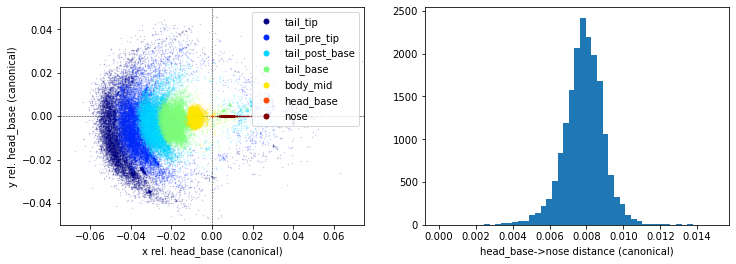

In [7]:
%matplotlib inline
fig,ax = plt.subplots(1,2,figsize=(12,4))

col = plt.cm.jet(np.linspace(0,1,7))
ax[0].axhline(0,color='k',linewidth=0.5,linestyle='--')
ax[0].axvline(0,color='k',linewidth=0.5,linestyle='--')
for i,o in enumerate(order):
    print(i,o,parts[i])
    ax[0].plot(px_rot[:,o],py_rot[:,o],'.',markersize=1,alpha=0.2,color=col[i])
    ax[0].plot(px_rot[0,o]+100,py_rot[0,o]+100,'.',markersize=10,alpha=1,color=col[i],label=parts[o])
ax[0].set_xlim([-0.075,0.075])
ax[0].set_ylim([-0.05,0.05])
ax[0].set_xlabel(f'x rel. {rot_parts[0]} (canonical)')
ax[0].set_ylabel(f'y rel. {rot_parts[0]} (canonical)')
ax[0].legend()

_ = ax[1].hist(px_rot[:,rotI[1]],bins=np.linspace(0,0.015,50))
ax[1].set_xlabel(f'{rot_parts[0]}->{rot_parts[1]} distance (canonical)')

fig.savefig('./_plots/pose_stats.pdf')